In [2]:
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns


import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'

sys.path.append(str(SCRIPTS_PATH))

# from scrape_weather_data import weather_scraper

In [3]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET / filename)

df_tt = load_data('Turbine_telemetry.csv')
df_rd = load_data('Residential_demand.csv')
df_wd = load_data('kirkwall_weather.csv')

print(f"turbine telemetry shape: {df_tt.shape}")
print(f"residential demand shape: {df_rd.shape}")
print(f"weather data shape: {df_wd.shape}")

turbine telemetry shape: (1069636, 4)
residential demand shape: (17568, 3)
weather data shape: (16584, 9)


In [4]:
df_rd['Timestamp'] = pd.to_datetime(df_rd['Timestamp'])

# Cleaning Turbine Telemetry Data

## Removing Data Points Where Wind Speed Is Fast Enough But No Power

In [5]:
# Find the minimum wind speed for power production
v_min = df_tt[(df_tt.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile minimum speed

print(f"minimum wind speed for power production: {v_min:.2f} m/s")

# Select only rows with Setpoint_kw == 900
df_tt = df_tt.query('Setpoint_kw==900').copy()

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df_tt.loc[((df_tt.Wind_ms >= v_min) & (df_tt.Power_kw.abs() <= 1e-5))] = np.nan

# remove all missing values from the dataframe
df_tt.dropna(inplace=True)

# Convert timestamp to datetime
df_tt['Timestamp'] = pd.to_datetime(df_tt['Timestamp'])

# Clip the power to the setpoint 900 kW
df_tt['Power_kw'] = df_tt['Power_kw'].clip(upper=900)

print(f"turbine telemetry data shape: {df_tt.shape}")

df_tt.head()

minimum wind speed for power production: 5.00 m/s
turbine telemetry data shape: (931575, 4)


Timestamp  Power_kw  Setpoint_kw  Wind_ms
0 2015-05-28 00:00:23      80.0        900.0      4.9
1 2015-05-28 00:01:23      78.0        900.0      5.4
2 2015-05-28 00:02:23      52.0        900.0      4.9
3 2015-05-28 00:03:23      57.0        900.0      4.6
4 2015-05-28 00:04:23      54.0        900.0      4.6

In [6]:
df_tt_timeindex = df_tt.copy()

# Set the timestamp as index 
df_tt_timeindex['Timestamp'] = pd.to_datetime(df_tt_timeindex['Timestamp'])

df_tt_timeindex = df_tt_timeindex.set_index('Timestamp')

# Resample the data to 30-minute intervals
df_tt_resampled = df_tt_timeindex.resample('30min').mean()

# Select the data for the year 2017
df_tt_resampled_2017 = df_tt_resampled[
    (df_tt_resampled.index >= '2017-01-01') &
    (df_tt_resampled.index < '2018-01-02')
]


## Clean Resampled

In [7]:
df_tt_resampled['Month'] = df_tt_resampled.index.to_period('M')
df_tt_resampled['Month_int'] = df_tt_resampled['Month'].dt.month
df_tt_resampled['Year_int'] = df_tt_resampled.index.to_period('Y').year

df_tt_resampled.head()

Power_kw  Setpoint_kw    Wind_ms    Month  Month_int  \
Timestamp                                                                     
2015-05-28 00:00:00  103.000000        900.0   5.533333  2015-05          5   
2015-05-28 00:30:00  204.000000        900.0   7.040000  2015-05          5   
2015-05-28 01:00:00  285.600000        900.0   7.876667  2015-05          5   
2015-05-28 01:30:00  457.266667        900.0   9.166667  2015-05          5   
2015-05-28 02:00:00  890.133333        900.0  12.973333  2015-05          5   

                     Year_int  
Timestamp                      
2015-05-28 00:00:00      2015  
2015-05-28 00:30:00      2015  
2015-05-28 01:00:00      2015  
2015-05-28 01:30:00      2015  
2015-05-28 02:00:00      2015

## Clean Original Timeseries

In [8]:
df_tt['Month'] = df_tt['Timestamp'].dt.to_period('M')
df_tt['Month_int'] = df_tt['Month'].dt.month
df_tt['Year_int'] = df_tt['Timestamp'].dt.year

df_tt.head()

Timestamp  Power_kw  Setpoint_kw  Wind_ms    Month  Month_int  \
0 2015-05-28 00:00:23      80.0        900.0      4.9  2015-05          5   
1 2015-05-28 00:01:23      78.0        900.0      5.4  2015-05          5   
2 2015-05-28 00:02:23      52.0        900.0      4.9  2015-05          5   
3 2015-05-28 00:03:23      57.0        900.0      4.6  2015-05          5   
4 2015-05-28 00:04:23      54.0        900.0      4.6  2015-05          5   

   Year_int  
0      2015  
1      2015  
2      2015  
3      2015  
4      2015

# Scraped Weather Data Cleaning

In [9]:

df_wd = load_data('kirkwall_weather.csv')
# Cleaning weather data
df_wd = df_wd.rename(columns={'Time': 'Timestamp'})
# Convert timestamp to datetime
df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])

# Sort value based on timestamp
df_wd = df_wd.sort_values('Timestamp').reset_index(drop=True)

# aligning timestamp 00:20 into 00:30 and 00:50 to 01:00
df_wd['Timestamp'] = df_wd.Timestamp.apply(lambda x: x + pd.Timedelta(minutes=10))

df_wd['Wind Speed (m/s)'] = pd.to_numeric(df_wd['Wind Speed (m/s)'], errors='coerce').fillna(0.0)


print(f"Weather scrape columns: {df_wd.columns}")
df_wd.head()

Weather scrape columns: Index(['Timestamp', 'Icon', 'Temperature (F)', 'Description',
       'Wind Speed (m/s)', 'Wind Direction', 'Humidity (%)', 'Pressure (Hg)',
       'Visibility (mi)'],
      dtype='object')


Timestamp             Icon  Temperature (F)      Description  \
0 2017-01-01 00:30:00  Passing clouds.               41  Passing clouds.   
1 2017-01-01 01:00:00      Quite cool.               43      Quite cool.   
2 2017-01-01 01:30:00  Passing clouds.               41  Passing clouds.   
3 2017-01-01 02:00:00  Passing clouds.               39  Passing clouds.   
4 2017-01-01 02:30:00  Passing clouds.               41  Passing clouds.   

   Wind Speed (m/s)                                     Wind Direction  \
0             10.28  Wind blowing from 340° North-northwest to Sout...   
1              9.39  Wind blowing from 330° North-northwest to Sout...   
2              9.83  Wind blowing from 340° North-northwest to Sout...   
3              7.15  Wind blowing from 330° North-northwest to Sout...   
4              8.94  Wind blowing from 330° North-northwest to Sout...   

   Humidity (%)  Pressure (Hg)  Visibility (mi)  
0          81.0          30.04              NaN  
1          81.0          30.04              NaN  
2          87.0          30.04              NaN  
3          87.0          30.07              5.0  
4          76.0          30.07              NaN

## Join TT with Scraped Data

In [10]:
df_tt_resampled_2017 = df_tt_resampled_2017.reset_index()

# inner join resample 2017 turbine telemetry data with weather data  
df_tt_wd = pd.merge(
    df_wd[['Timestamp', 'Wind Speed (m/s)']],
    df_tt_resampled_2017[['Timestamp', 'Wind_ms', 'Power_kw']],
    how='inner',
    on='Timestamp'
)

# Rename columns for clarity
df_tt_wd = df_tt_wd.rename(columns={
    'Wind Speed (m/s)': 'Wind_speed_scraped',
    'Wind_ms': 'Wind_speed_baseline',
    'Power_kw': 'Power_baseline'
})

# Ensure Timestamp is a datetime
df_tt_wd['Timestamp'] = pd.to_datetime(df_tt_wd['Timestamp'])

# Create a 'Month' column for grouping
df_tt_wd['Month'] = df_tt_wd['Timestamp'].dt.to_period('M')
df_tt_wd['Month_int'] = df_tt_wd['Month'].dt.month


# Show result
df_tt_wd.head()


Timestamp  Wind_speed_scraped  Wind_speed_baseline  \
0 2017-01-01 00:30:00               10.28            16.106667   
1 2017-01-01 01:00:00                9.39            16.380000   
2 2017-01-01 01:30:00                9.83            17.083333   
3 2017-01-01 02:00:00                7.15            16.800000   
4 2017-01-01 02:30:00                8.94            18.021739   

   Power_baseline    Month  Month_int  
0      893.266667  2017-01          1  
1      897.633333  2017-01          1  
2      899.966667  2017-01          1  
3      900.000000  2017-01          1  
4      899.956522  2017-01          1

# Scrape and Baseline Analysis

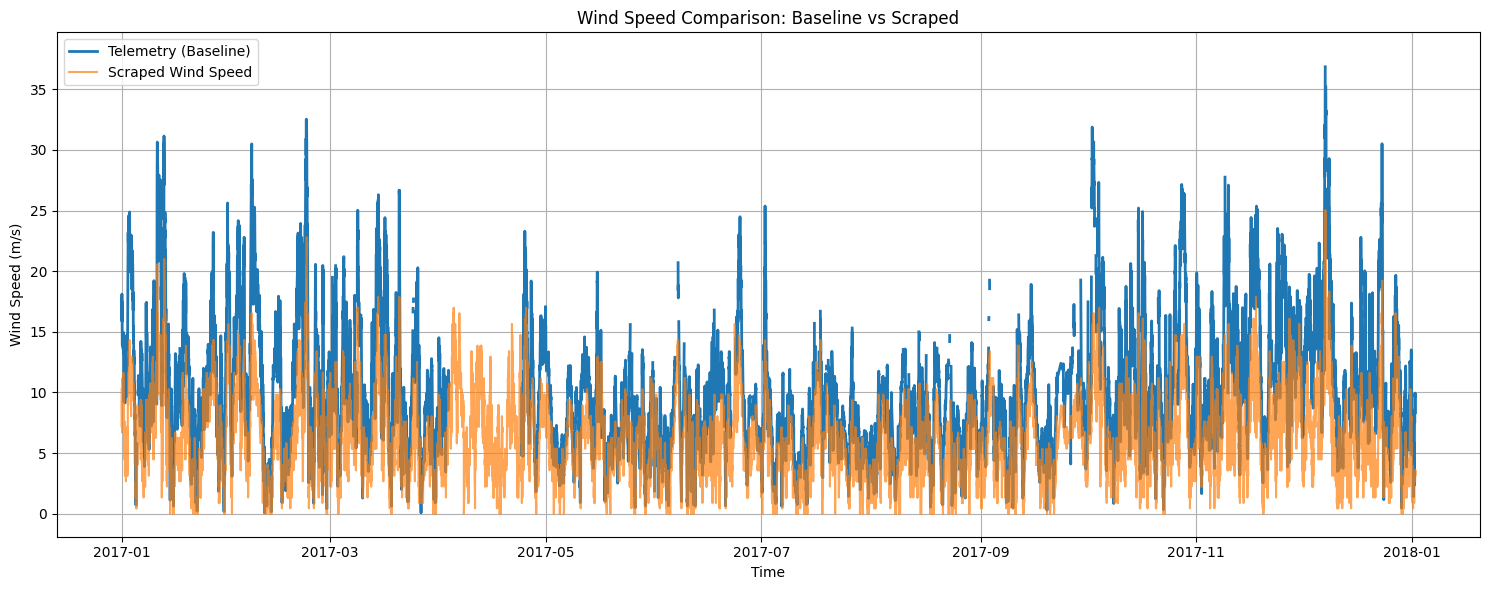

In [11]:
# Plot over time
plt.figure(figsize=(15, 6))

plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_baseline'], label='Telemetry (Baseline)', linewidth=2)
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_scraped'], label='Scraped Wind Speed', alpha=0.7)
# plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_monthly_scaled'], label='Corrected Wind Speed', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Comparison: Baseline vs Scraped')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Correlation Scraped-Baseline

In [12]:
# Calculation Correlation Between Wind Speed and Wind Speed Baseline
correlation = df_tt_wd['Wind_speed_scraped'].corr(df_tt_wd['Wind_speed_baseline'])
print("Correlation:", correlation)


Correlation: 0.8423381870134377


## Scaling with Monthly Percentage Differences

In [13]:
# Calculate monthly means
monthly_means = df_tt_wd.groupby('Month')[['Wind_speed_scraped', 'Wind_speed_baseline']].mean()

# Calculate correction factors
monthly_means['correction_factor'] = monthly_means['Wind_speed_baseline'] / monthly_means['Wind_speed_scraped']

# Join the correction factor back to the main dataframe
df_tt_wd = df_tt_wd.merge(monthly_means['correction_factor'], on='Month', how='left')

# Apply the correction
df_tt_wd['Wind_speed_monthly_scaled'] = df_tt_wd['Wind_speed_scraped'] * df_tt_wd['correction_factor']

monthly_means.head()


Wind_speed_scraped  Wind_speed_baseline  correction_factor
Month                                                              
2017-01            7.024976            11.909933           1.695370
2017-02            6.836293            11.803518           1.726596
2017-03            6.335610            10.563270           1.667285
2017-04            7.347837            10.880955           1.480838
2017-05            5.313900             7.740323           1.456618

In [14]:
# New Dataframe with the correction factor and scaled wind speed
df_tt_wd.head()

Timestamp  Wind_speed_scraped  Wind_speed_baseline  \
0 2017-01-01 00:30:00               10.28            16.106667   
1 2017-01-01 01:00:00                9.39            16.380000   
2 2017-01-01 01:30:00                9.83            17.083333   
3 2017-01-01 02:00:00                7.15            16.800000   
4 2017-01-01 02:30:00                8.94            18.021739   

   Power_baseline    Month  Month_int  correction_factor  \
0      893.266667  2017-01          1            1.69537   
1      897.633333  2017-01          1            1.69537   
2      899.966667  2017-01          1            1.69537   
3      900.000000  2017-01          1            1.69537   
4      899.956522  2017-01          1            1.69537   

   Wind_speed_monthly_scaled  
0                  17.428404  
1                  15.919524  
2                  16.665487  
3                  12.121896  
4                  15.156608

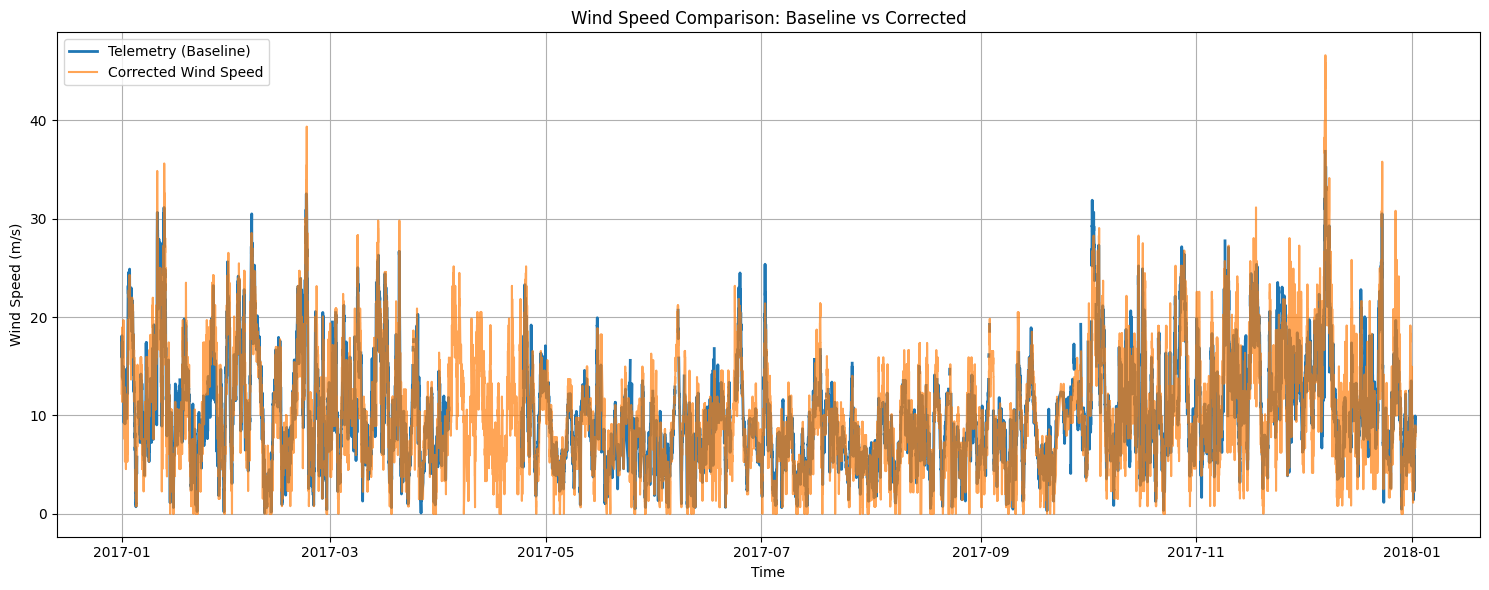

In [15]:
# Plot over time
plt.figure(figsize=(15, 6))

plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_baseline'], label='Telemetry (Baseline)', linewidth=2)
# plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_scraped'], label='Scraped Wind Speed', alpha=0.7)
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_monthly_scaled'], label='Corrected Wind Speed', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Comparison: Baseline vs Corrected')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scale with Z-Scale

In [16]:
# I dont think its correct to scale with z-scale since it is not a normal distribution

# Energy Generated

$$
\begin{equation*} P(v)=\displaystyle \frac{1}{2}\rho Av^{3}C_{p}.\tag{1}\end{equation*}
$$

Where:

* $P$ = power output (in watts, W)
* $\rho$ = air density (in kg/m³), typically \~1.176 kg/m³ at at a height of 60 m above ground.
* $A$ = swept area of the rotor (in m²), $A = \pi r^2$
* $v$ = wind speed (in m/s)
* $C_p$ = power coefficient (efficiency), typically $\leq 0.59$ due to **Betz's limit**

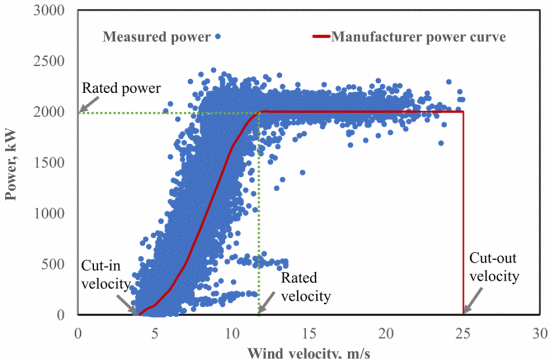

The output power is zero in Region 1 or in the range [0,$v_{ci}$ [. The cut-in speed, $v_{ci}$, is thus the minimal wind speed below which the output power is non-zero. The wind turbine must resist its own inertia to begin rotating the blades in that zone.

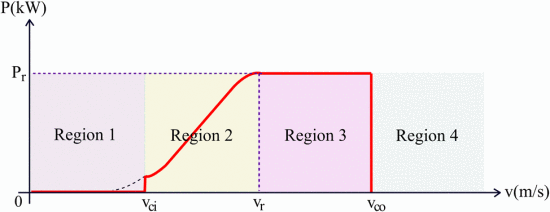

[Source](https://ieeexplore.ieee.org/document/10063743)

In [17]:
df_tt_wd.head()

Timestamp  Wind_speed_scraped  Wind_speed_baseline  \
0 2017-01-01 00:30:00               10.28            16.106667   
1 2017-01-01 01:00:00                9.39            16.380000   
2 2017-01-01 01:30:00                9.83            17.083333   
3 2017-01-01 02:00:00                7.15            16.800000   
4 2017-01-01 02:30:00                8.94            18.021739   

   Power_baseline    Month  Month_int  correction_factor  \
0      893.266667  2017-01          1            1.69537   
1      897.633333  2017-01          1            1.69537   
2      899.966667  2017-01          1            1.69537   
3      900.000000  2017-01          1            1.69537   
4      899.956522  2017-01          1            1.69537   

   Wind_speed_monthly_scaled  
0                  17.428404  
1                  15.919524  
2                  16.665487  
3                  12.121896  
4                  15.156608

### Deriving Rotor Radius

In [18]:
# Constants
rho = 1.225  # air density in kg/m³
cp = 0.35    # power coefficient
pi = np.pi

# Only use data where baseline power is below setpoint
valid = (df_tt_wd['Power_baseline'] < 880) & (df_tt_wd['Power_baseline'] > 20)

# Use the corrected wind speed and power baseline
P = df_tt_wd.loc[valid, 'Power_baseline'] * 1000  # convert kW to W
v = df_tt_wd.loc[valid, 'Wind_speed_baseline']

# Avoid division by zero or very small wind speeds
safe = v > 0
P = P[safe]
v = v[safe]

# Calculate rotor radius and diameter
r = np.sqrt((2 * P) / (rho * pi * v**3 * cp))

print(f"Mean rotor radius: {r.mean()} m")
print(f"Standard deviation of rotor radius: {r.std()} m")
print(f"Min rotor radius: {r.min()} m")
print(f"Max rotor radius: {r.max()} m")





Mean rotor radius: 25.87889655327397 m
Standard deviation of rotor radius: 3.6624578715335585 m
Min rotor radius: 1.0085586470582693 m
Max rotor radius: 40.83395682948988 m


## Theoritical With Clipping

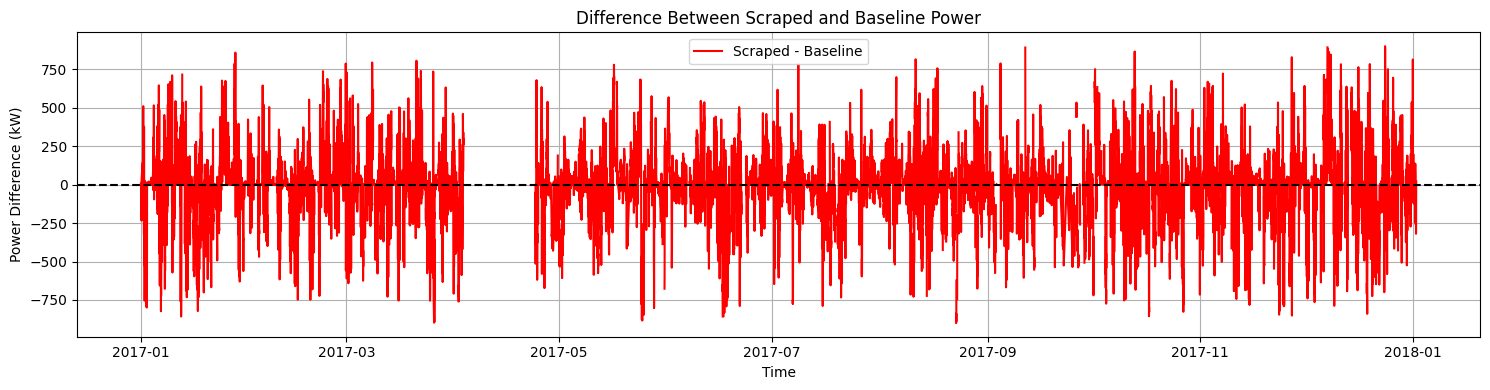

In [84]:
_r = r.mean()

def naive_power(v:float,rho:float=1.225, r:float = _r ,cp:float= 0.35) -> float:
    return 0.5 * rho * (np.pi * (r**2)) * (v**3) * cp / 1000
    
df_tt_wd['Potential_theoretical_energy'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: naive_power(v, r = _r))

#add cap to 900
df_tt_wd['Naive_Power_scraped'] = df_tt_wd['Potential_theoretical_energy'].clip(upper=900)

#visualize

df_tt_wd['Naive_Power_diff'] = df_tt_wd['Naive_Power_scraped'] - df_tt_wd['Power_baseline']

plt.figure(figsize=(15, 4))
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Naive_Power_diff'], color='red', label='Scraped - Baseline')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Power Difference (kW)')
plt.title('Difference Between Scraped and Baseline Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
from sklearn.metrics import mean_squared_error,r2_score

# Only compare where both values are available (i.e., not NaN)
valid_mse = df_tt_wd[['Naive_Power_scraped', 'Power_baseline']].dropna()

mse_naive = mean_squared_error(valid_mse['Power_baseline'], valid_mse['Naive_Power_scraped'])
rmse_naive = np.sqrt(mse_naive)
r2_naive = r2_score(valid_mse['Power_baseline'], valid_mse['Naive_Power_scraped'])

print(f"Naive MSE: {mse_naive:.2f} kW²")
print(f"Naive RMSE: {rmse_naive:.2f} kW")
print(f"Naive R² Score: {r2_naive:.4f}")

Naive MSE: 49610.15 kW²
Naive RMSE: 222.73 kW
Naive R² Score: 0.5587


## Weibull Cumulative Distribution Power Output Model

$$
\begin{equation*} P(\nu)=P_r\left(1-e^{-\left(\frac{v-v_0}{c}\right)^3}\right),\tag{10}\end{equation*}
$$


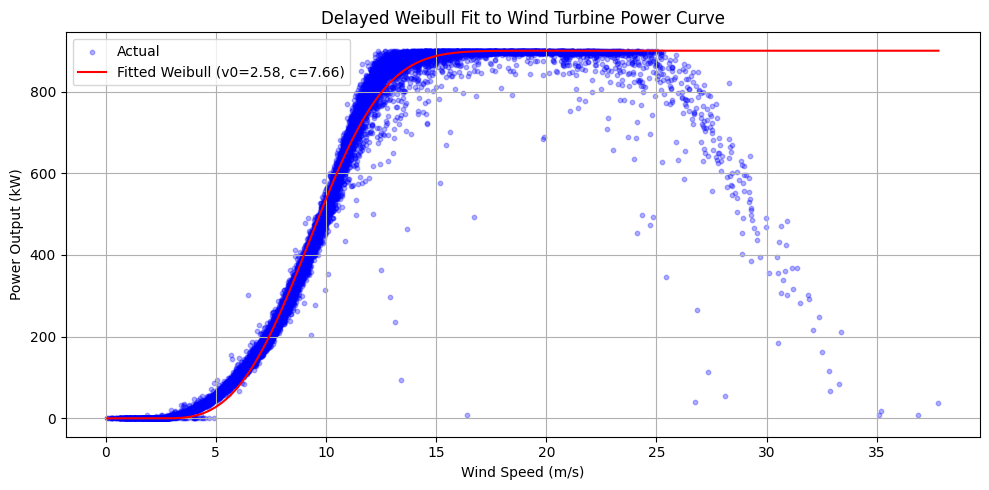

(np.float64(2.583001282770365), np.float64(7.664525041260357))

In [86]:
from scipy.optimize import curve_fit

def delayed_weibull(v:float, v0:float, c:float, pr:float):
    """
    Weibull model for wind speed distribution.
    
    Parameters:
    pr (float): Power rating of the turbine in kW. (or setpoint in our case i think)
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the Weibull distribution in m/s.
    
    Returns:
    float: Power output in kW.
    """
    v = np.asarray(v)
    power = np.zeros_like(v)
    mask = v > v0
    power[mask] = pr * (1 - np.exp(-((v[mask] - v0) / c) ** 3))
    return power

#remove nan values and convert to values
df_model = df_tt_wd.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])
wind = df_model['Wind_speed_baseline'].values
power = df_model['Power_baseline'].values


# Initial guesses for v0 and c
initial_guess = [2.7, 6.5]

# Fit curve
popt, pcov = curve_fit(lambda v, v0, c: delayed_weibull(v, v0, c, pr=900), wind, power, p0=initial_guess)


# Predicted values using fitted parameters
v0_fit, c_fit = popt
predicted_power = delayed_weibull(wind, v0_fit, c_fit, pr=900)

# Plot actual vs fitted curve
v_sorted = np.sort(wind)


predicted_sorted = delayed_weibull(v_sorted, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

### Using Our Wind data

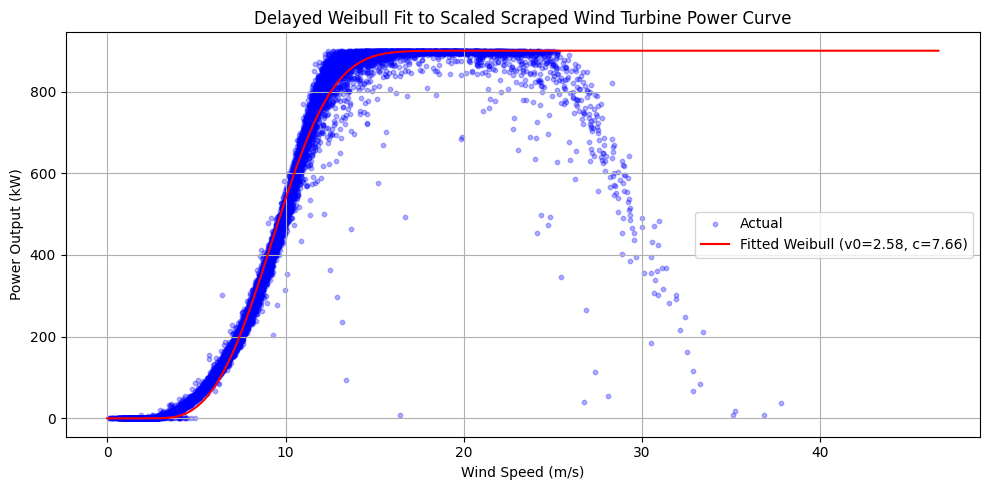

In [87]:
sorted_scaled_wind = np.sort(df_tt_wd['Wind_speed_monthly_scaled'].dropna())
# Predicted values using fitted parameters
predicted_sorted = delayed_weibull(sorted_scaled_wind, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(sorted_scaled_wind, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Scaled Scraped Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the Weibull power curve using the fitted parameters
df_tt_wd['Weibull_Power'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: delayed_weibull(v, v0_fit, c_fit, pr=900))

Weilbull Mean Absolute Error (MAE): 147.3472394054607
Weilbull Root Mean Squared Error (RMSE): 222.25203119446147
Weilbull R² Score: 0.5606101800680148


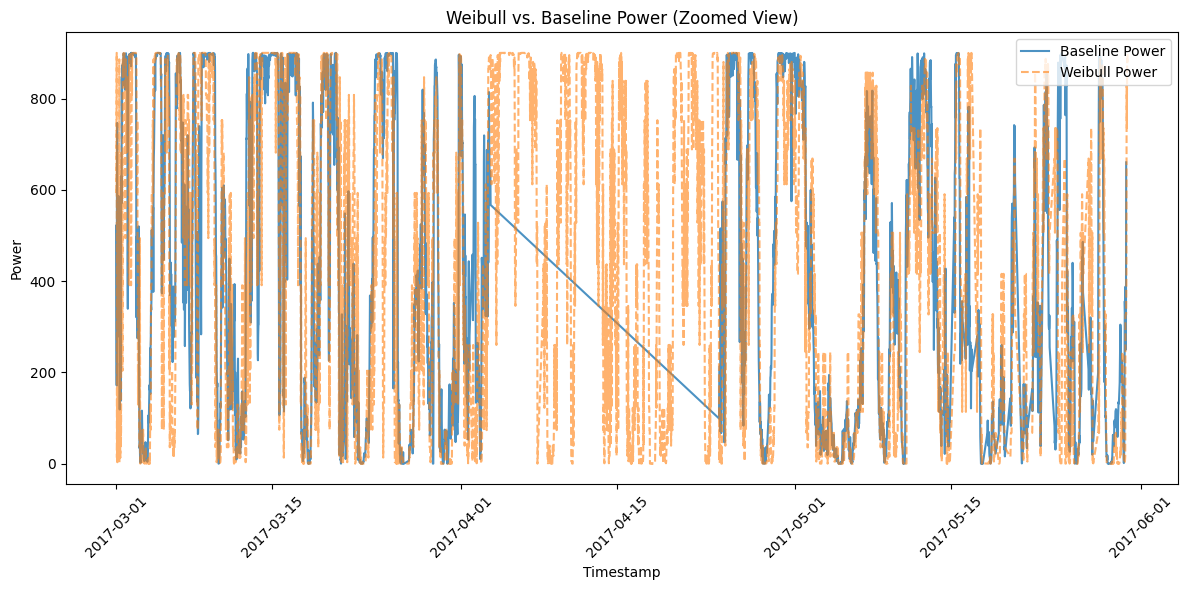

In [89]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
# Load your data (replace with actual path or DataFrame)
# df = pd.read_csv('your_data.csv')

# --- Statistical Comparison ---
valid_stats = df_tt_wd[['Weibull_Power', 'Power_baseline']].dropna()
mae_wb = mean_absolute_error(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])
rmse_wb = root_mean_squared_error(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])
r2_wb = r2_score(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])

print("Weilbull Mean Absolute Error (MAE):", mae_wb)
print("Weilbull Root Mean Squared Error (RMSE):", rmse_wb)
print("Weilbull R² Score:", r2_wb)

# --- Plotting Comparison ---
df_zoom = df_tt_wd[(df_tt_wd['Timestamp'] >= '2017-03-01') & (df_tt_wd['Timestamp'] <= '2017-05-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Timestamp', y='Power_baseline', data=df_zoom, label='Baseline Power', linestyle='-', alpha=0.8)
sns.lineplot(x='Timestamp', y='Weibull_Power', data=df_zoom, label='Weibull Power', linestyle='--', alpha=0.6)
plt.title('Weibull vs. Baseline Power (Zoomed View)')
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.xticks(rotation=45)
#set legend position
plt.legend(loc='upper right') # change position of legend
plt.tight_layout()
plt.show()


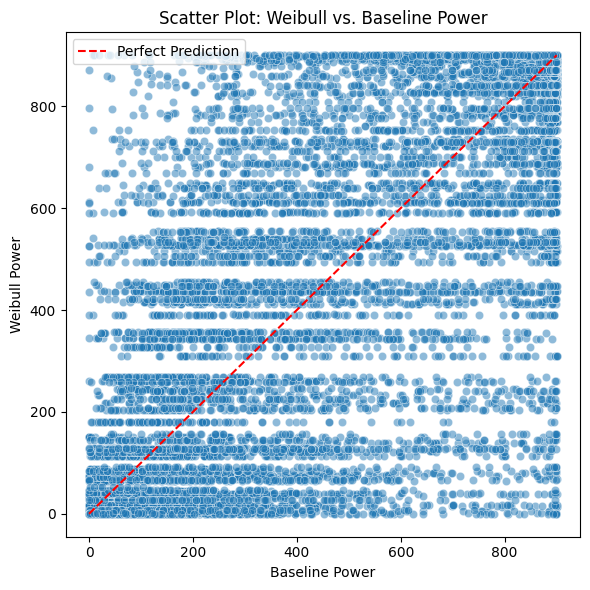

In [90]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Power_baseline', y='Weibull_Power', data=df_tt_wd, alpha=0.5)
plt.plot([df_tt_wd['Power_baseline'].min(), df_tt_wd['Power_baseline'].max()],
         [df_tt_wd['Power_baseline'].min(), df_tt_wd['Power_baseline'].max()],
         'r--', label='Perfect Prediction')
plt.title('Scatter Plot: Weibull vs. Baseline Power')
plt.xlabel('Baseline Power')
plt.ylabel('Weibull Power')
plt.legend()
plt.tight_layout()
plt.show()


## 3PL

$$
\begin{equation*} P(\nu)=P_{r}\displaystyle \frac{1}{1+e^{-\gamma(\nu-v_{0})^{3}}},\tag{12}\end{equation*}
$$

/var/folders/9s/vnh0yrb52292pp21phjjlqpm0000gn/T/ipykernel_39155/3595162123.py:14: RuntimeWarning: overflow encountered in exp
  return pr * (1 / (1 + np.exp(-gamma * (v - v0)**3)))


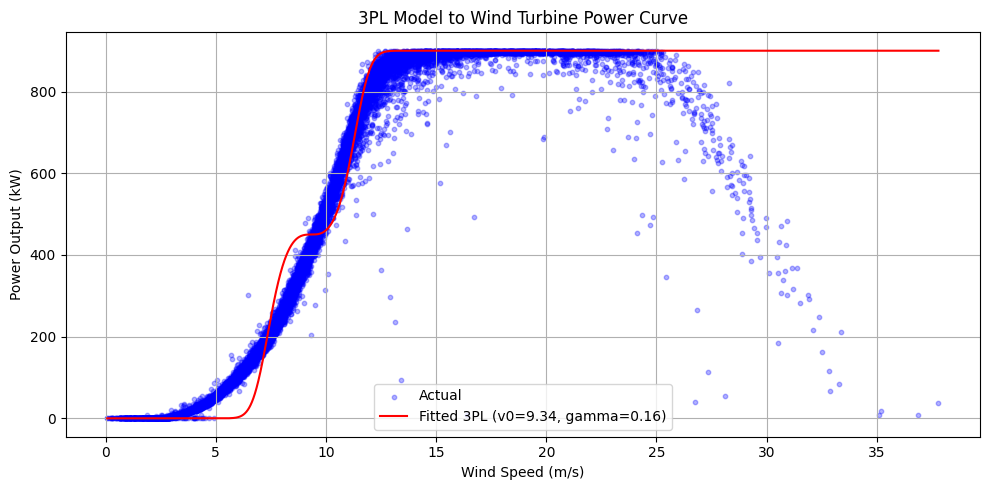

(np.float64(9.335692373869865), np.float64(7.664525041260357))

In [91]:
def three_pl(v, v0, gamma, pr):
    """
    Logistic model for wind speed distribution.
    
    Parameters:
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the logistic distribution in m/s.
    gamma (float): Shape parameter of the logistic distribution.
    pr (float): Power rating of the turbine in kW.
    
    Returns:
    float: Power output in kW.
    """
    return pr * (1 / (1 + np.exp(-gamma * (v - v0)**3)))

#remove nan values and convert to values
df_model = df_tt_wd.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])
wind = df_model['Wind_speed_baseline'].values
power = df_model['Power_baseline'].values


# Initial guesses for v0 and gamma
initial_guess = [1, 2]

# Fit curve
popt, pcov = curve_fit(lambda v, v0, gamma: three_pl(v, v0, gamma, pr=900), wind, power, p0=initial_guess)


# Predicted values using fitted parameters
v0_fit, g_fit = popt
predicted_power = three_pl(wind, v0_fit, g_fit, pr=900)

# Plot actual vs fitted curve
v_sorted = np.sort(wind)


predicted_sorted = three_pl(v_sorted, v0_fit, g_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted 3PL (v0={v0_fit:.2f}, gamma={g_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('3PL Model to Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

3PL Mean Absolute Error (MAE): 159.44644411696268
3PL Root Mean Squared Error (RMSE): 236.74507916062308
3PL R² Score: 0.5014365524763966


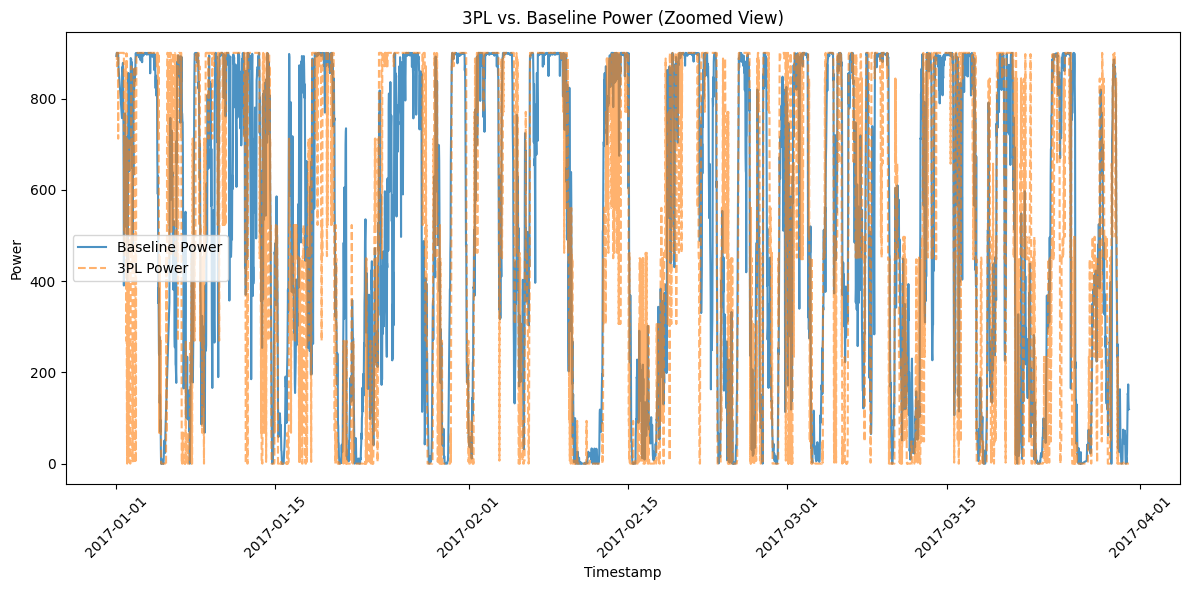

In [92]:
df_tt_wd['3PL_Power'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: three_pl(v, v0_fit, g_fit, pr=900))

# --- Statistical Comparison ---
valid_stats = df_tt_wd[['3PL_Power', 'Power_baseline']].dropna()
mae_3pl = mean_absolute_error(valid_stats['Power_baseline'], valid_stats['3PL_Power'])
rmse_3pl = root_mean_squared_error(valid_stats['Power_baseline'], valid_stats['3PL_Power'])
r2_3pl = r2_score(valid_stats['Power_baseline'], valid_stats['3PL_Power'])

print("3PL Mean Absolute Error (MAE):", mae_3pl)
print("3PL Root Mean Squared Error (RMSE):", rmse_3pl)
print("3PL R² Score:", r2_3pl)

# --- Plotting Comparison ---
df_zoom = df_tt_wd[(df_tt_wd['Timestamp'] >= '2017-01-01') & (df_tt_wd['Timestamp'] <= '2017-03-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Timestamp', y='Power_baseline', data=df_zoom, label='Baseline Power', linestyle='-', alpha=0.8)
sns.lineplot(x='Timestamp', y='3PL_Power', data=df_zoom, label='3PL Power', linestyle='--', alpha=0.6)
plt.title('3PL vs. Baseline Power (Zoomed View)')
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [93]:
df_tt_wd.to_csv(PROCESSED_DATASET / 'Turbine_telemetry_power_models_v1.csv', index=False)

df_tt_wd.head()


Timestamp  Wind_speed_scraped  Wind_speed_baseline  \
0 2017-01-01 00:30:00               10.28            16.106667   
1 2017-01-01 01:00:00                9.39            16.380000   
2 2017-01-01 01:30:00                9.83            17.083333   
3 2017-01-01 02:00:00                7.15            16.800000   
4 2017-01-01 02:30:00                8.94            18.021739   

   Power_baseline    Month  Month_int  correction_factor  \
0      893.266667  2017-01          1            1.69537   
1      897.633333  2017-01          1            1.69537   
2      899.966667  2017-01          1            1.69537   
3      900.000000  2017-01          1            1.69537   
4      899.956522  2017-01          1            1.69537   

   Wind_speed_monthly_scaled  Naive_Power_scraped  Naive_Power_diff  \
0                  17.428404           900.000000          6.733333   
1                  15.919524           900.000000          2.366667   
2                  16.665487           900.000000          0.033333   
3                  12.121896           803.391324        -96.608676   
4                  15.156608           900.000000          0.043478   

   Weibull_Power   3PL_Power  Potential_theoretical_energy  
0     899.371249  900.000000                   2387.747263  
1     895.362966  900.000000                   1819.725114  
2     898.178475  900.000000                   2087.707087  
3     769.065192  870.702911                    803.391324  
4     889.114144  900.000000                   1570.440795

## Compare Three Approaches

In [29]:
comparison_df = pd.DataFrame({
    "Model": ["Naive", "Weibull", "3PL"],
    "MAE": [np.nan,mae_wb, mae_3pl],
    "RMSE": [rmse_naive,rmse_wb, rmse_3pl],
    "R²": [r2_naive,r2_wb, r2_3pl]
})

comparison_df

Model         MAE        RMSE        R²
0    Naive         NaN  222.733353  0.558705
1  Weibull  147.347239  222.252031  0.560610
2      3PL  159.446444  236.745079  0.501437

Weibull function appear to be the better for modelling the wind turbine power curve.

## Demand TS Analaysis

In [148]:
df_rd.head()

df_rd['Month_int'] = df_rd['Timestamp'].dt.month
df_rd['Date'] = df_rd['Timestamp'].dt.date
ts_rd = df_rd.set_index('Timestamp').copy()

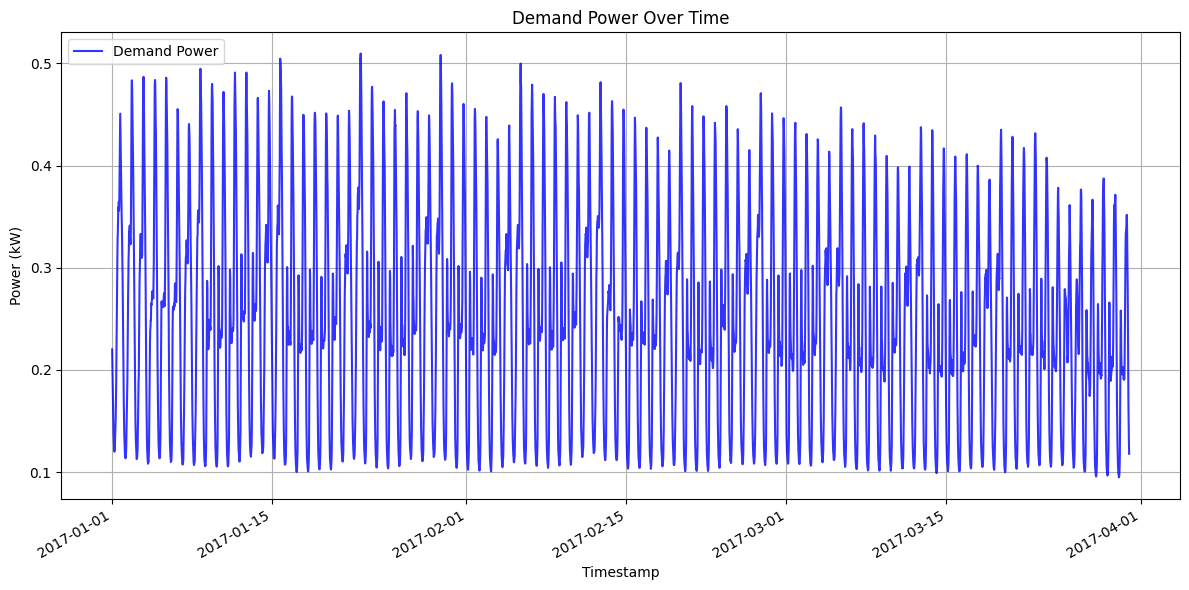

In [142]:
df_rd_zoom = df_rd[(df_rd['Timestamp'] >= '2017-01-01') & (df_rd['Timestamp'] <= '2017-03-31')]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_rd_zoom['Timestamp'], df_rd_zoom['Demand_mean_kw'], label='Demand Power', color='blue', alpha=0.8)
ax.set_title('Demand Power Over Time')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Power (kW)')
ax.legend(loc='upper left')
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Decomposition

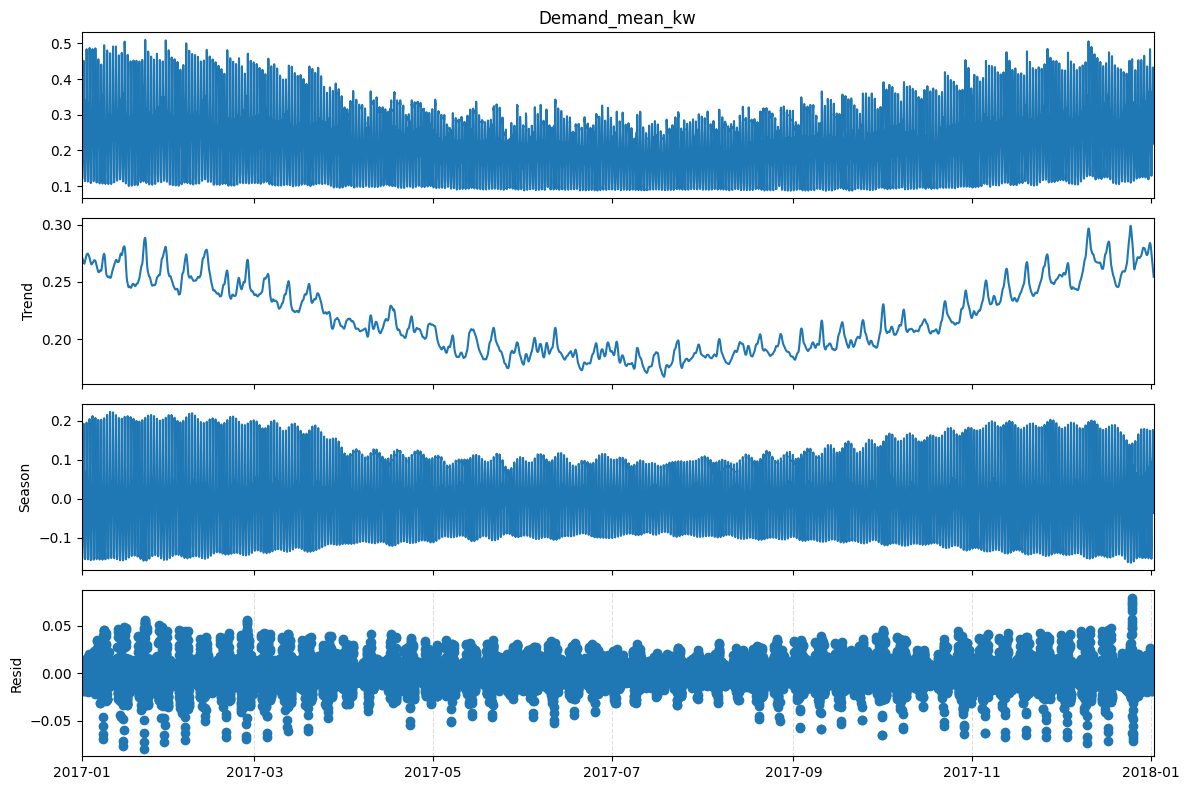

In [144]:
from statsmodels.tsa.seasonal import STL


stl = STL(ts_rd['Demand_mean_kw'], period=48)  # data is in 30-minute intervals, so period=48 for daily seasonality
res = stl.fit()

# Plot with custom size and layout
fig = res.plot()
fig.set_size_inches(12, 8)  # width, height in inches
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()


Since the data is from Orkney, Scotland, the pattern starts to make a lot more sense. Orkney has a cool and often windy climate, with long daylight hours in the summer and short, dark days in the winter. A lot of homes rely on electricity for heating and lighting, especially in rural areas where other energy options might be limited.

The sudden jump in demand around September probably marks the start of colder weather. People begin using electric heaters, lights, and maybe cooking indoors more often as the days get shorter. After that spike, the drop could reflect people adjusting their usage—maybe they shift to off-peak times, turn things off more consciously, or just settle into a winter routine. Then as it gets colder and darker into December, demand slowly builds up again.

The daily pattern also becomes more extreme later in the year. That’s likely because people use more electricity in the mornings and evenings when it's darker and colder outside. So the bigger daily swings in the seasonal component match what you’d expect for Orkney’s winter life—lights on earlier, heaters running longer, and more indoor activity overall.

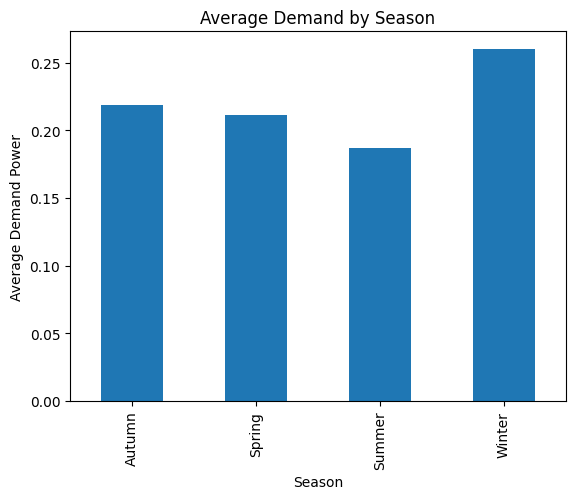

In [146]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

ts_rd['Season'] = ts_rd['Month_int'].apply(get_season)

ts_rd.groupby('Season')['Demand_mean_kw'].mean().plot(kind='bar', title='Average Demand by Season')
plt.ylabel('Average Demand Power')
plt.show()

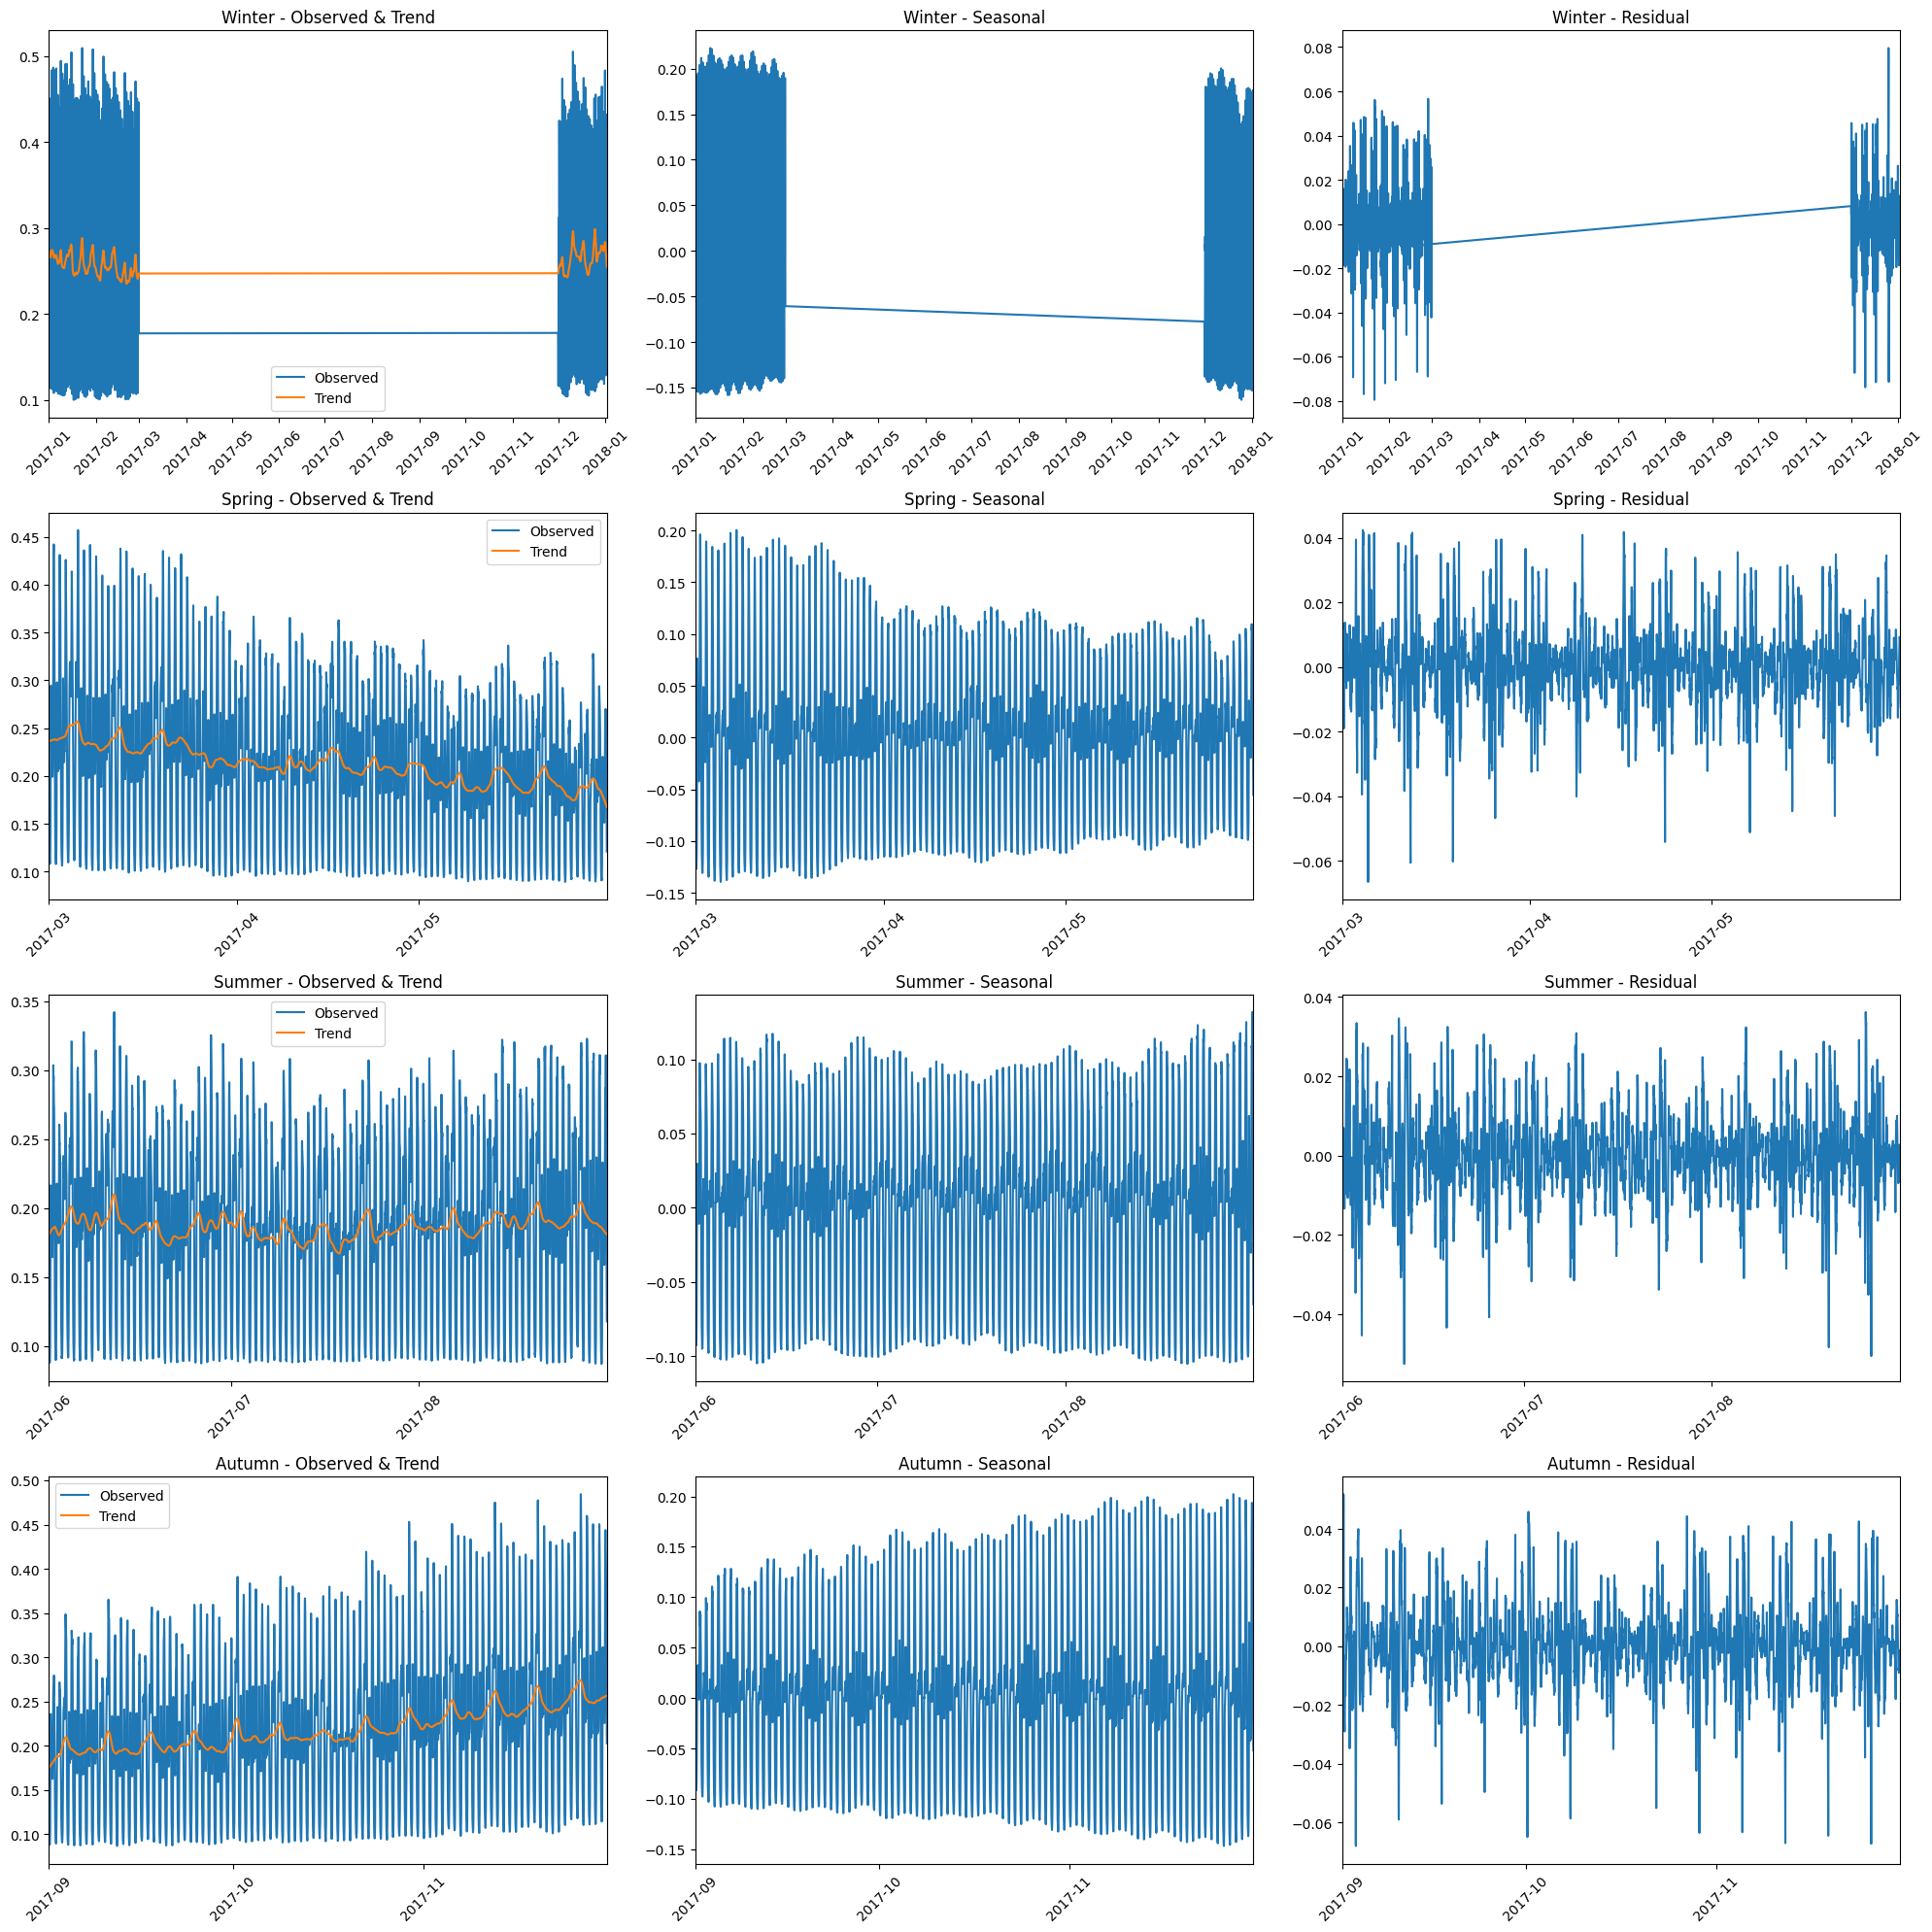

In [147]:
import matplotlib.dates as mdates

seasons = ts_rd['Season'].unique()
fig, axs = plt.subplots(len(seasons), 3, figsize=(20, 20), sharex=False)

for i, season in enumerate(seasons):
    seasonal_df = ts_rd[ts_rd['Season'] == season]
    stl = STL(seasonal_df['Demand_mean_kw'], period=48)
    res = stl.fit()

    # Get start and end for consistent x-axis
    x_start = seasonal_df.index.min()
    x_end = seasonal_df.index.max()

    # Observed + trend
    axs[i, 0].plot(seasonal_df.index, seasonal_df['Demand_mean_kw'], label='Observed')
    axs[i, 0].plot(seasonal_df.index, res.trend, label='Trend')
    axs[i, 0].set_title(f'{season} - Observed & Trend')
    axs[i, 0].legend()

    # Seasonal
    axs[i, 1].plot(seasonal_df.index, res.seasonal)
    axs[i, 1].set_title(f'{season} - Seasonal')

    # Residual
    axs[i, 2].plot(seasonal_df.index, res.resid)
    axs[i, 2].set_title(f'{season} - Residual')

    # Format x-axis for all three
    for ax in axs[i]:
        ax.set_xlim([x_start, x_end])
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Looking at the STL plots for each season, we can see clear changes in how people use electricity throughout the year. In winter, demand stays pretty steady at first, then shoots up toward the end of the season. The trend line backs that up, showing a big rise in overall usage most likely because it’s colder and darker, so people are using more heating and lights. The seasonal pattern doesn’t really kick in until later in the winter, which could mean more consistent daily routines or heavier use during mornings and evenings. The residuals in winter are a bit all over the place, especially as demand ramps up, suggesting there might have been some unusual events or just more unpredictable usage.

Spring and summer look much more stable. The demand and trend lines don’t move around much, and the seasonal patterns are really clear up and down like clockwork every day. That makes sense if people are following a consistent daily schedule and not relying as much on heating. The residuals are smaller too, which shows the model captures the patterns pretty well.

Autumn is a bit different. There’s a huge spike in demand at the start, then it settles into a flatter trend. That spike might be from a specific event or maybe the first cold snap of the season. The seasonal pattern is still there, but it changes shape a bit more than in spring or summer, which might mean people are slowly shifting their routines. The residuals are more scattered too, hinting that usage is harder to predict during this time.

Overall, spring and summer have regular, predictable patterns, while winter and autumn show more sudden changes and heavier electricity use, likely tied to weather and shorter days in Orkney.


### Stationary Test

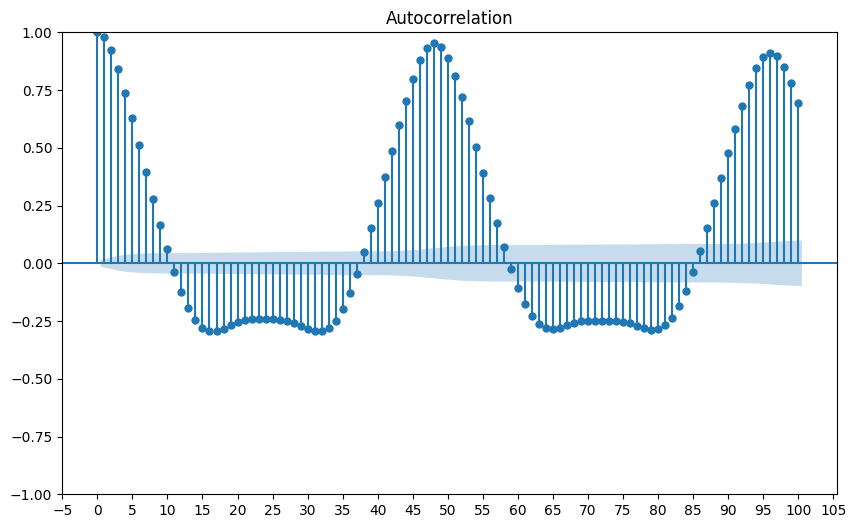

In [149]:
from matplotlib.ticker import MultipleLocator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size here
#set tick to every 5th value like 0, 5 
plot_acf(ts_rd['Demand_mean_kw'], lags=100, ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.show()

The auto correlation plot shows strong spike at lag 48. This correlate with our data that have interval of 30 minute that means in a day there will be in total 48 points.

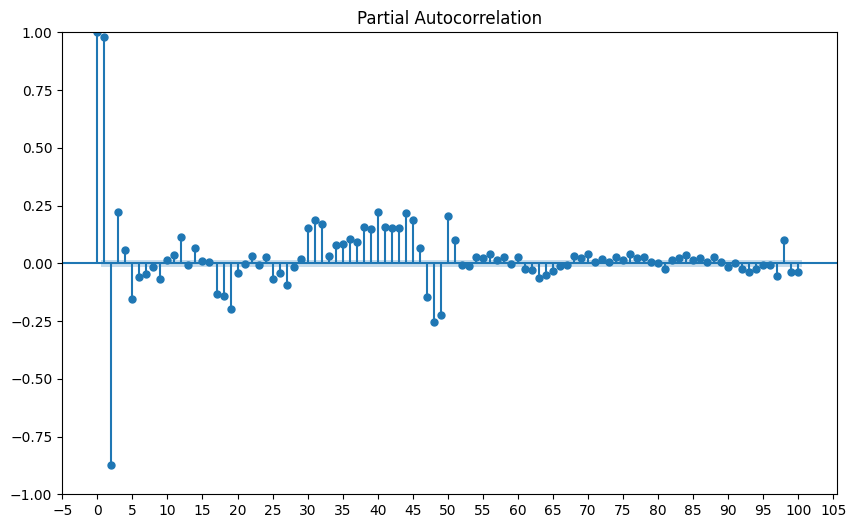

In [150]:
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size here
plot_pacf(ts_rd['Demand_mean_kw'], lags=100, ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.show()


A spike is present at lag 1 this means that there's a direct, strong positive relationship between the current value and the previous half-hour’s demand. However lag 2 shows a negative strong lag meaning the value two half-hours ago (1 hour ago) pulls the demand in the opposite direction after accounting for lag 1. This suggests that after a short rise in demand, there's often a quick drop like a correction of some sort. 

It might be due to for example, people might switch on appliances or heating for a short period, leading to a spike, but then usage falls soon after as those devices switch off or aren't needed anymore or the device is in idle. This kind of up-and-down pattern in a short time frame is common in residential settings, especially in the morning or evening when people are active for a limited window. The PACF structure points to a model where both lag 1 and lag 2 are important, possibly indicating short term oscillations in usage behavior.

In [154]:
ts_rd['Energy_kwh_per_household'] = ts_rd['Demand_mean_kw'] * 0.5  # Assuming 0.5 households per kW
daily_demand = ts_rd.groupby("Date")["Energy_kwh_per_household"].sum().reset_index()
avg_daily_demand = daily_demand['Energy_kwh_per_household'].mean()
max_demand = daily_demand['Energy_kwh_per_household'].max()

print(f"Average daily demand: {avg_daily_demand:.2f} kWh")
print(f"Min daily demand: {daily_demand['Energy_kwh_per_household'].min():.2f} kWh")
print(f"Max daily demand: {max_demand:.2f} kWh")

Average daily demand: 5.26 kWh
Min daily demand: 4.01 kWh
Max daily demand: 7.14 kWh


this is so low?? maybe cause only 41% use electric heating or it is controled? or maybe its a small house. a typical uk energy usage for a flat or 1-bedroom house is 4.93

Possible Appliances that can reach 7.14 kWh?:
* Fridge + Freezer 

# Curtailment

## Join Demand data with Processed Turbine Telemetry+Weather Data 

In [99]:
# join rd with df_tt_wd

df_tt_wd_rd = pd.merge(
    df_rd[['Timestamp', 'Demand_mean_kw','N_households']],
    df_tt_wd[['Timestamp', 'Wind_speed_monthly_scaled', 'Power_baseline', 'Weibull_Power', '3PL_Power']],
    how='inner',
    on='Timestamp'
)

df_tt_wd_rd['Timestamp'] = pd.to_datetime(df_tt_wd_rd['Timestamp'])

df_tt_wd_rd.head()

    

Timestamp  Demand_mean_kw  N_households  \
0 2017-01-01 00:30:00        0.205945          5429   
1 2017-01-01 01:00:00        0.189090          5429   
2 2017-01-01 01:30:00        0.173118          5429   
3 2017-01-01 02:00:00        0.159051          5429   
4 2017-01-01 02:30:00        0.147656          5429   

   Wind_speed_monthly_scaled  Power_baseline  Weibull_Power   3PL_Power  
0                  17.428404      893.266667     899.371249  900.000000  
1                  15.919524      897.633333     895.362966  900.000000  
2                  16.665487      899.966667     898.178475  900.000000  
3                  12.121896      900.000000     769.065192  870.702911  
4                  15.156608      899.956522     889.114144  900.000000

In [103]:
df_tt_wd_rd['Demand_mean_kw'].max()

np.float64(0.509661820699204)

## Curtailment Formula

$$
\text{Curtailment} = \text{Actual Generated Power} - (\text{Demand} + \text{Export})
$$

In [132]:
n_wind_turbines = 500

df_curtailment = pd.DataFrame({
    'Timestamp': df_tt_wd_rd['Timestamp'],
    'Date': df_tt_wd_rd['Timestamp'].dt.date,
    'Month_int': df_tt_wd_rd['Timestamp'].dt.month,
    'Generated_power': df_tt_wd_rd['Weibull_Power']*n_wind_turbines,
    'Demand_per_household': df_tt_wd_rd['Demand_mean_kw'],
    'N_households': df_tt_wd_rd['N_households'],
    'Demand_power': df_tt_wd_rd['Demand_mean_kw']*df_tt_wd_rd['N_households']
})
df_curtailment['Energy_kwh_per_household'] = df_curtailment['Demand_per_household'] * 0.5 # 30 min
df_curtailment['Energy_kwh_total'] = df_curtailment['Demand_per_household'] * df_curtailment['N_households'] * 0.5
df_curtailment['Curtailment_baseline'] = df_curtailment['Generated_power'] - df_curtailment['Demand_power']
df_curtailment['Generated_power_smooth'] = df_curtailment['Generated_power'].rolling(window=6, center=True).mean()
df_curtailment['Demand_power_smooth'] = df_curtailment['Demand_power'].rolling(window=6, center=True).mean()
df_curtailment['Curtailment_baseline_smooth'] = df_curtailment['Curtailment_baseline'].rolling(window=6, center=True).mean()


print(f"Max Generated Power: {df_curtailment['Generated_power'].max()}")
print(f"Max Demand Power: {df_curtailment['Demand_power'].max()}")
print(f"Max Curtailment: {df_curtailment['Curtailment_baseline'].max()}")
print(f"Min Generated Power: {df_curtailment['Generated_power'].min()}")
print(f"Min Demand Power: {df_curtailment['Demand_power'].min()}")
print(f"Min Curtailment: {df_curtailment['Curtailment_baseline'].min()}")
print(f"Columns: {df_curtailment.columns}")

Max Generated Power: 450000.0
Max Demand Power: 9688.176000000001
Max Curtailment: 449410.53
Min Generated Power: 0.0
Min Demand Power: 568.0880000000001
Min Curtailment: -9688.176000000001
Columns: Index(['Timestamp', 'Date', 'Month_int', 'Generated_power',
       'Demand_per_household', 'N_households', 'Demand_power',
       'Energy_kwh_per_household', 'Energy_kwh_total', 'Curtailment_baseline',
       'Generated_power_smooth', 'Demand_power_smooth',
       'Curtailment_baseline_smooth'],
      dtype='object')


## Comparing Generated, Demand and Curtailment

## Orkney Reports Summary

---

### Income & Cost of Living

- Orkney has **lower than average income** compared to the Scottish average (£34,619).
  - Average income in Orkney’s Isles is **~£10,000 below the Scottish average**.
- **Higher living costs** due to geographic isolation:
  - It costs on average **20% more** to live in rural island areas.
  - Costs rise to **~30% more** for smaller remote islands like Orkney’s outer isles.
  - Increased costs affect:
    - Food shopping
    - Transport
    - Energy bills

- Implications:
  - **Significant fuel poverty** risk, especially in outer islands.
  - Even Mainland Orkney households face affordability challenges.

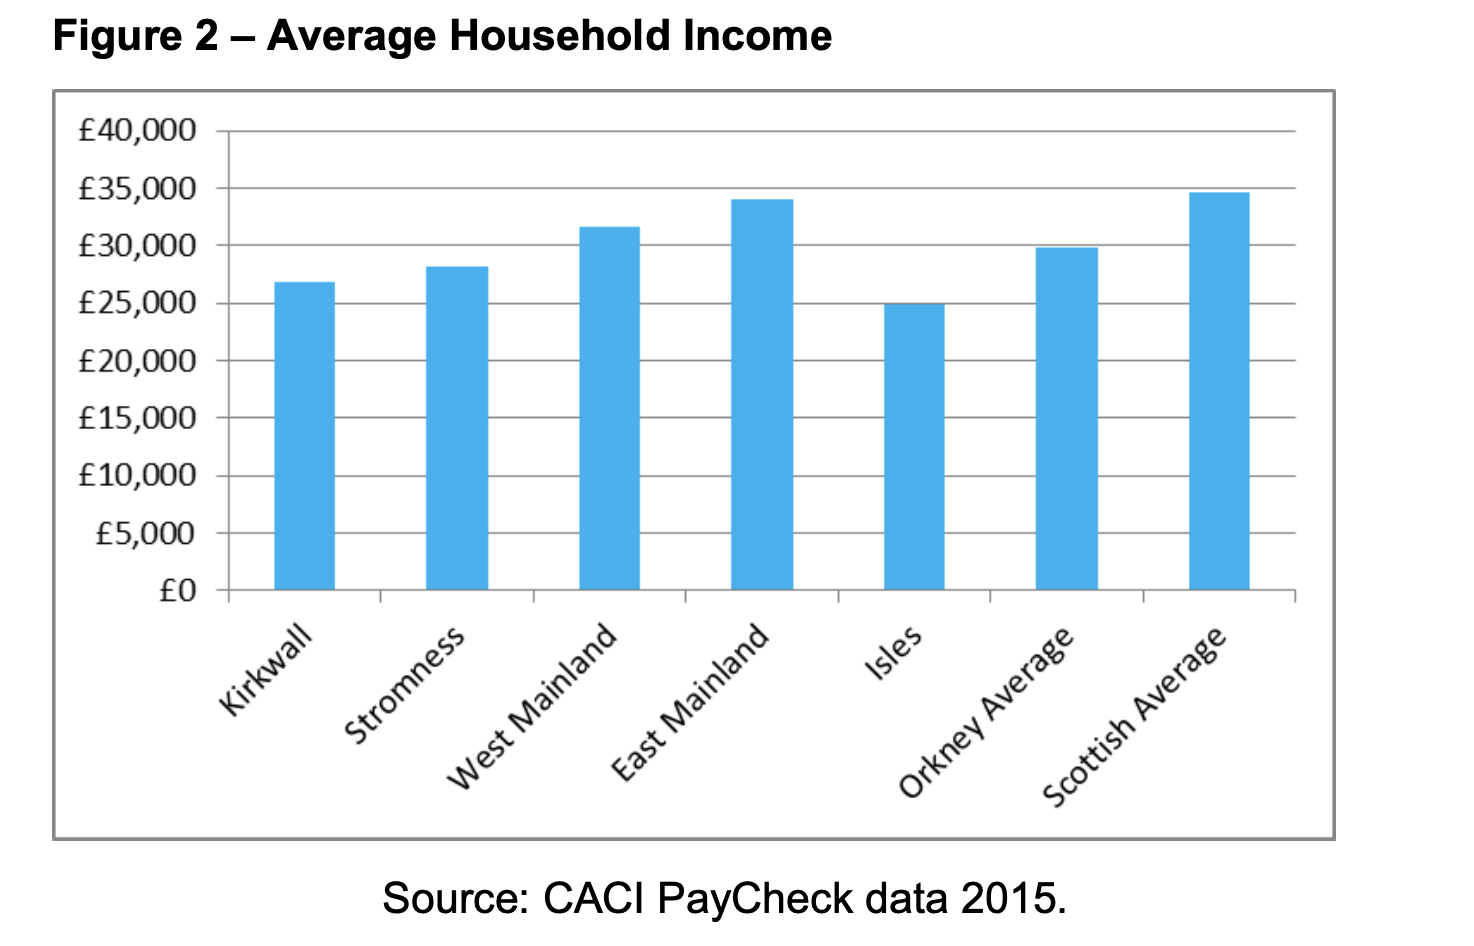

---

### Heating Types

- **41% of households** use **electric heating** (per 2011 Census).
- **36% of households** use **oil heating**.
- Other findings:
  - Affordable Warmth Survey estimates **25–30%** oil use.
- **Electricity consumption**:
  - Orkney average: **8,193 kWh/year**
  - Scotland average: **4,465 kWh/year**
  - UK average: **4,092 kWh/year**
- **Energy cost comparison**:
  - Mains gas: ~3.34p per kWh
  - North Scotland electricity: ~15.61p per kWh

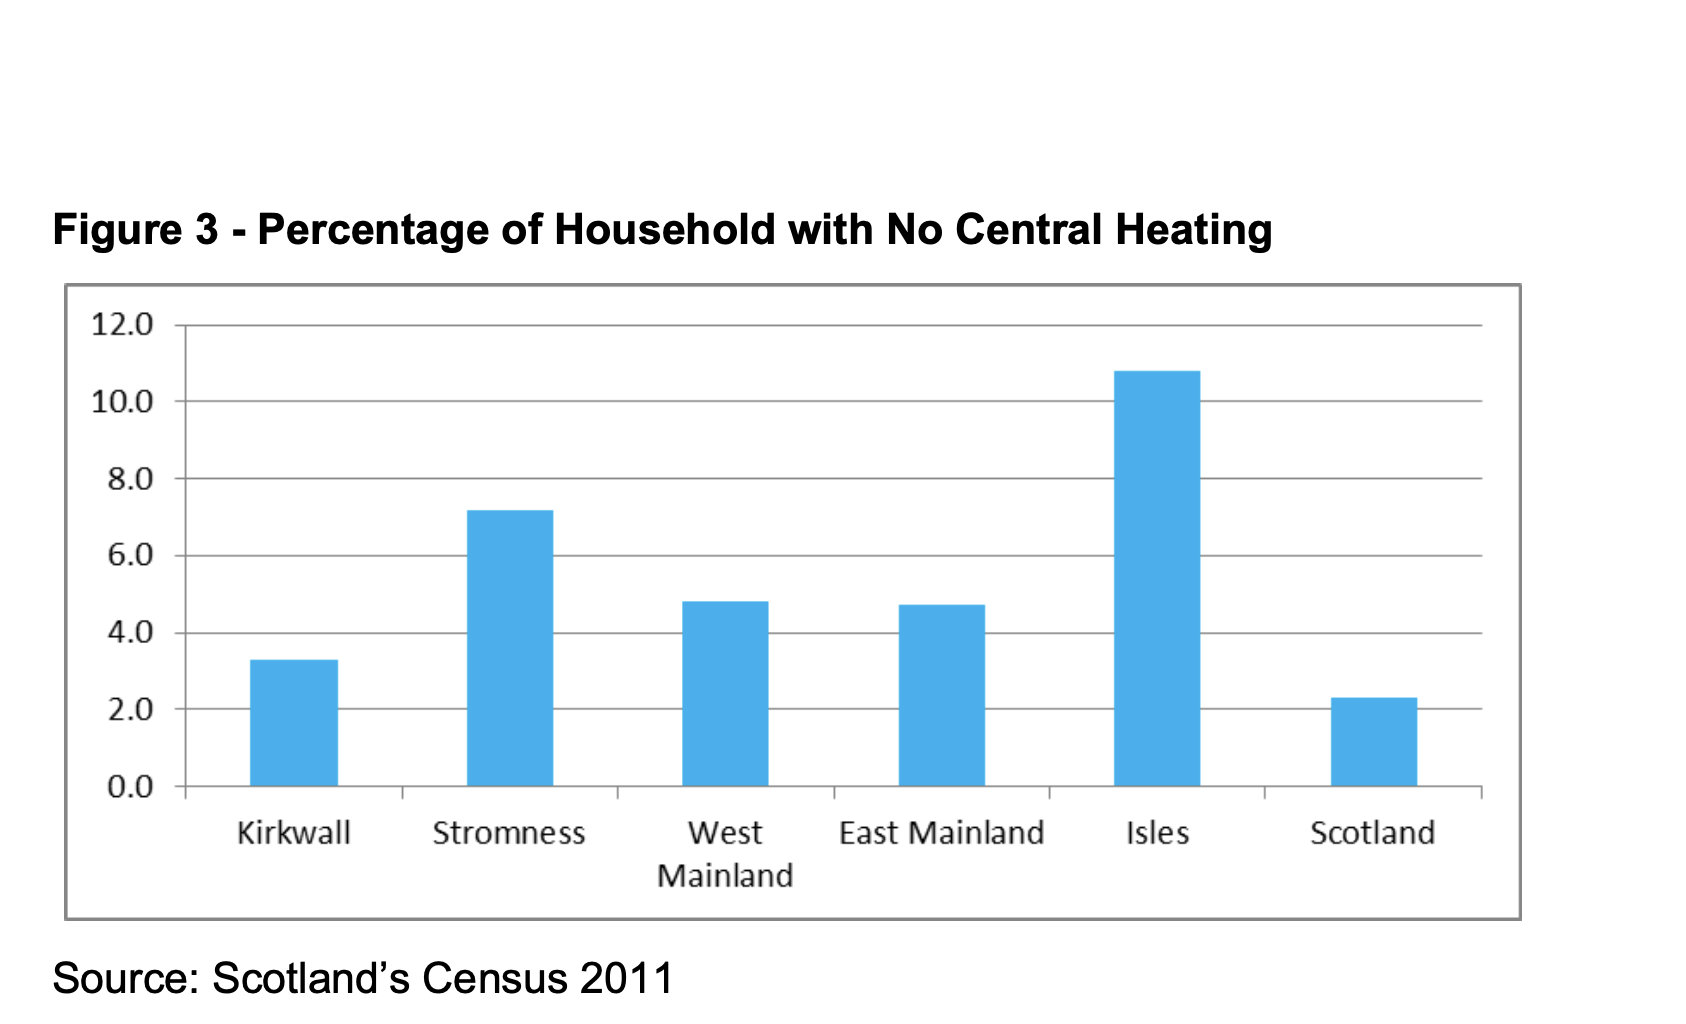

---

### Housing Stock & Energy Efficiency

- Age and condition of homes directly impact fuel poverty.
- Key stats:
  - **~25%** of housing is **pre-1919** (low energy efficiency).
  - Majority of new development occurred **post-1983** (better efficiency).
  - Older stock is mostly in the **private rented sector**.
  - **Kirkwall**, **West Mainland**, and **East Mainland**:
    - Less than 30% pre-1919 housing
    - More than 45% of homes are post-1983 (owner-occupied or social housing)
  - **Isles**: Nearly **50% of homes are pre-1919**

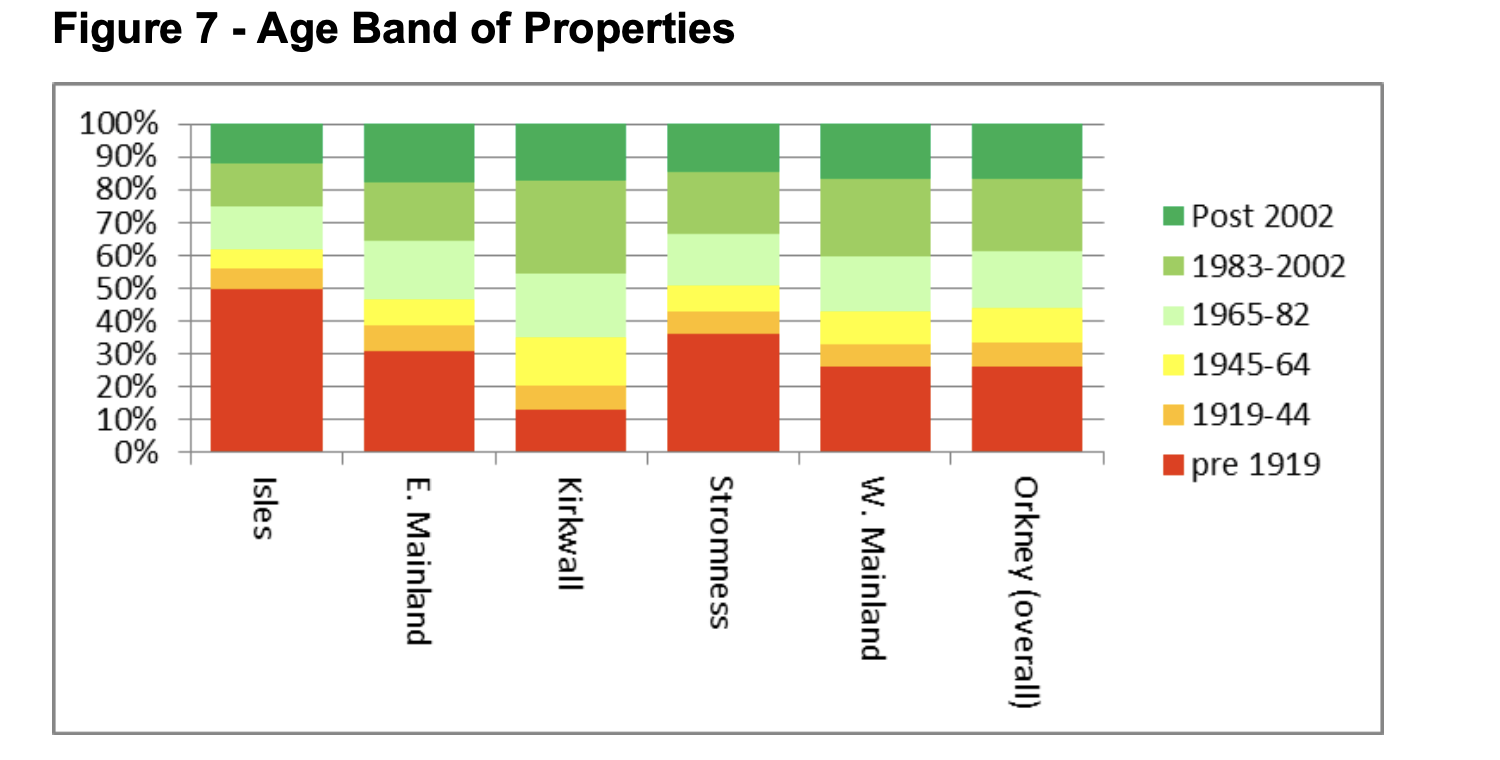

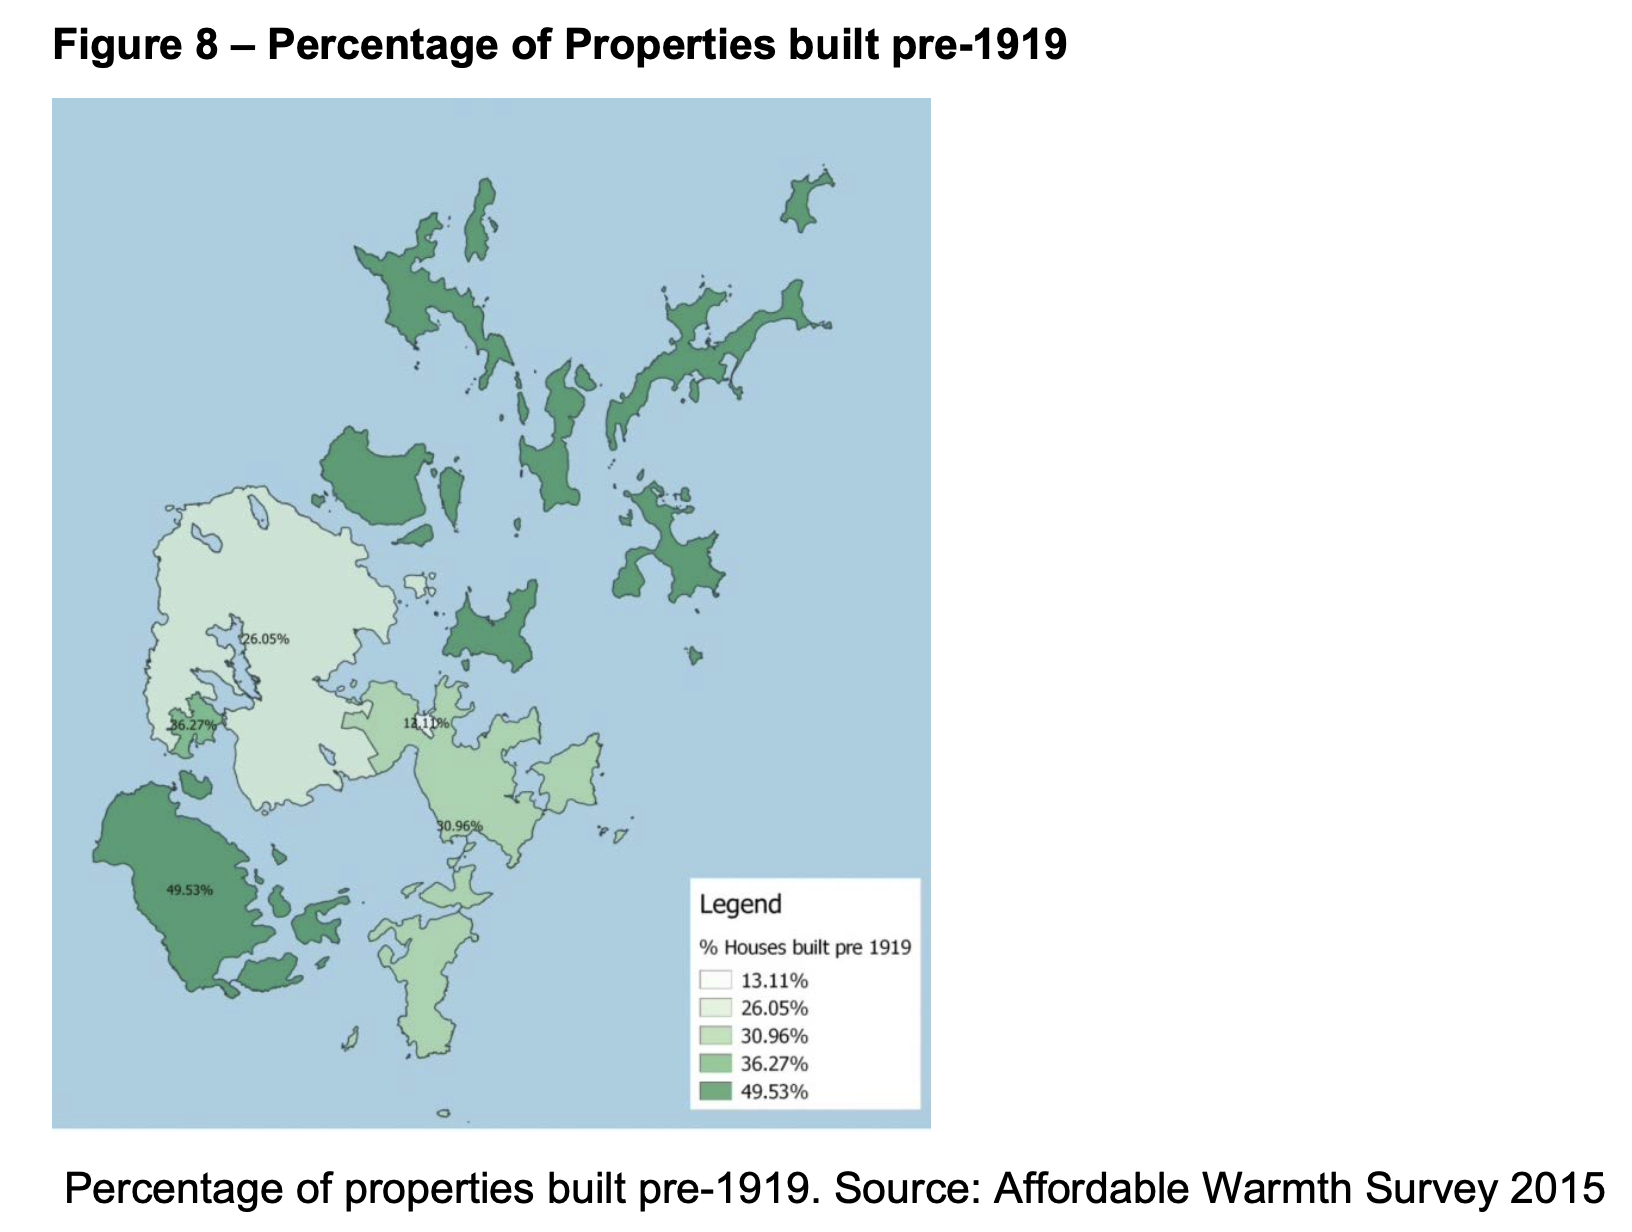

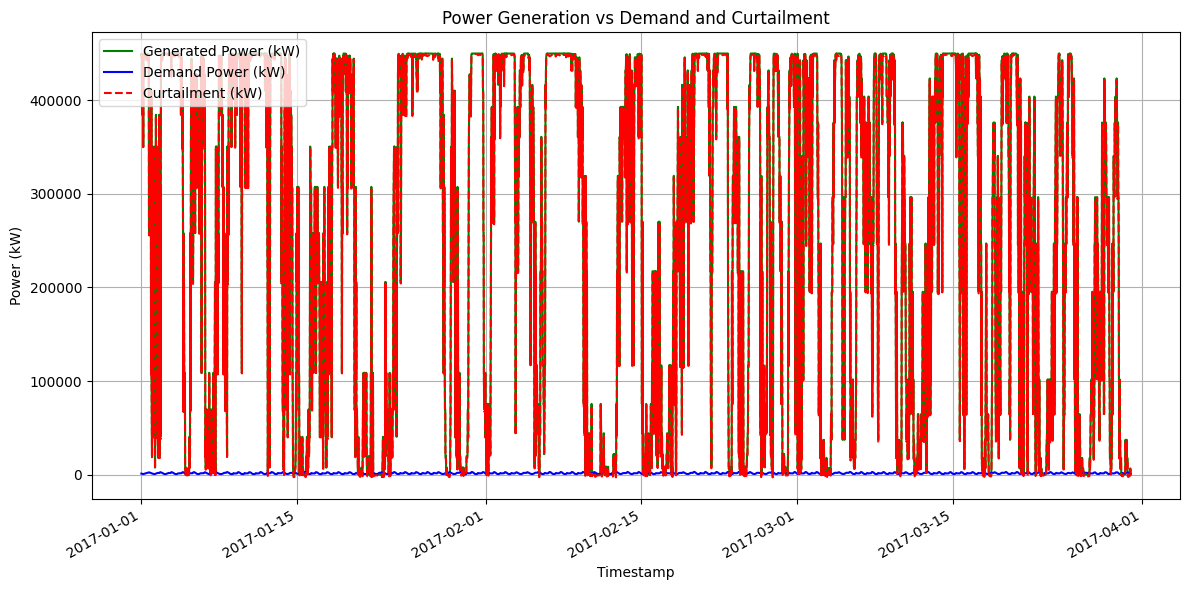

In [140]:
df_curtailment_zoom = df_curtailment[(df_curtailment['Timestamp'] >= '2017-01-01') & (df_curtailment['Timestamp'] <= '2017-03-31')]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Generated Power
ax.plot(df_curtailment_zoom['Timestamp'], df_curtailment_zoom['Generated_power'],
        label='Generated Power (kW)', color='green')

# Demand Power
ax.plot(df_curtailment_zoom['Timestamp'], df_curtailment_zoom['Demand_power'],
        label='Demand Power (kW)', color='blue')

# Curtailment
ax.plot(df_curtailment_zoom['Timestamp'], df_curtailment_zoom['Curtailment_baseline'],
        label='Curtailment (kW)', color='red', linestyle='--')

# Labels and formatting
ax.set_title('Power Generation vs Demand and Curtailment')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Power (kW)')
ax.legend(loc='upper left')
ax.grid(True)
fig.autofmt_xdate()  # Still rotates date labels nicely

# Save the plot
plt.tight_layout()
# plt.savefig(FIGURES_PATH / "curtailment_plot.png", dpi=300)
plt.show()
